# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.448307,False,2.583374
1,-0.470247,False,-2.583443
2,0.419880,False,0.976406
3,-1.612021,True,2.622802
4,-0.007599,False,0.189429
...,...,...,...
995,-0.440922,False,-1.687991
996,-0.456682,False,0.519231
997,-0.374730,False,-0.600430
998,-0.550234,True,4.558195


<AxesSubplot: xlabel='v0'>

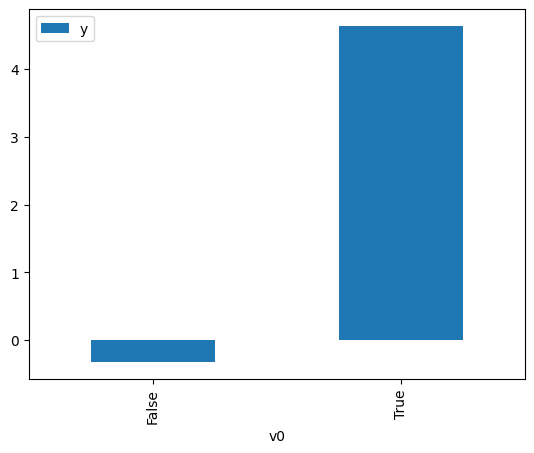

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

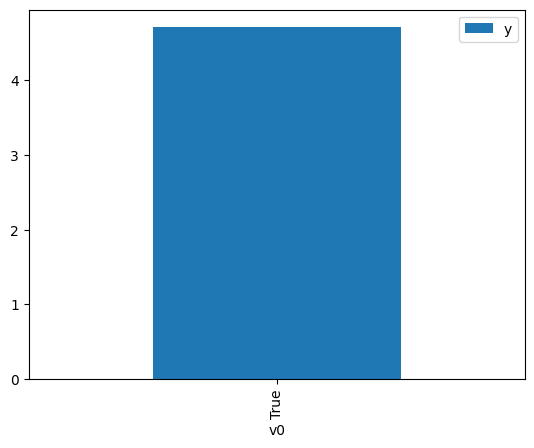

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.178289,False,0.943390,0.522375,1.914334
1,-0.138558,False,-0.717078,0.533172,1.875569
2,-1.369696,False,-3.039239,0.574739,1.739919
3,0.249897,False,1.206098,0.519932,1.923330
4,0.181109,False,-0.691829,0.522279,1.914687
...,...,...,...,...,...
995,0.866898,False,1.355754,0.498852,2.004605
996,0.375760,False,0.957872,0.515635,1.939357
997,1.623464,False,3.650159,0.473017,2.114091
998,0.258020,False,1.058596,0.519654,1.924356


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.725065,True,5.076699,0.496300,2.014909
1,-0.547173,True,5.698406,0.452952,2.207741
2,0.023733,True,6.177792,0.472355,2.117051
3,1.280481,True,6.678500,0.515281,1.940689
4,-2.034758,True,1.696689,0.403200,2.480158
...,...,...,...,...,...
995,1.950486,True,8.610877,0.538114,1.858342
996,0.141006,True,6.740938,0.476353,2.099282
997,0.257372,True,4.981728,0.480324,2.081930
998,-1.518561,True,2.193492,0.420293,2.379290


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              7514.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):                        0.00
Time:                        16:10:13   Log-Likelihood:                         -1409.0
No. Observations:                1000   AIC:                                      2822.
Df Residuals:                     998   BIC:                                      2832.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9422      0.031     63.436      0.000       1.882       2.002
x2             4.9965      0.046    108.615      0.000       4.906       5.087
==============================================================================
Omnibus:                        0.774   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.690
Skew:                           0.060   Prob(JB):                        0.708
Kurtosis:                       3.044   Cond. No.                         1.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""